# CSCI 4260 HW1

In this assignment, we will implement the **logistic regression** algorithm using PyTorch and use it to classify an image dataset. The goal of this assignment is to make you familiar with pytorch and undstand the idea behind classification. Let's start by importing the required packages.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

%matplotlib inline

## Logistic Regression

In class, we looked at and discussed the main idea of logistic regression. Let's quickly review background materials. Suppose we have a dataset $D$ consisting of $n$ examples $\{(x_i, y_i)\}_{i=1}^n$, where $(x_i, y_i)\sim \mathcal{P}$. The logistic regression model (for binary classification) $f:\mathbb{R}^p \to \{0, 1\}$ takes a **feature vector** $x \in \mathbb{R}^p$ an input and maps it to a value in $\mathcal{Y}\in \{0, 1\}$. The model is given by 
$$
    f(x) = \Pr[Y=1~|~X=x] = \sigma(w^\intercal x)\,,
$$
where $\sigma(x) = \frac{1}{1+e^{-x}}$ is the *sigmoid* function.
1. Given a feature vector $X=x$, it first computes a *linear combination* $w^\intercal x$.
2. Apply the sigmoid function to squash the output into the range $[0, 1]$.

As a warm-up, let's look at some properties of sigmoid function. You need to **type** your answer using the **Markdown**. Go through examples in [**this**](https://www.markdownguide.org/basic-syntax/) page, which will provide you an overview of Markdown syntax. In Markdown, there are two modes of mathematical equations: inline vs display. To write an *inline* equation, enclose the script of dollar (`$`) signs. For example, `$\int_a^b f(x) \mathrm{d}x$`. When executed, this will be displayed as $\int_a^b f(x) \mathrm{d}x$. To show it in the *display mode*, you can enclose your equations with double dollar signs `$$ [your equation] $$`. For example,
$$ \int_a^b f(x) \mathrm{d}x\,. $$
To see how to type mathmatical equations, see these pages:
1. [https://en.wikibooks.org/wiki/LaTeX/Mathematics](https://en.wikibooks.org/wiki/LaTeX/Mathematics)
2. [https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols](https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols)

### Q1. Compute the first order derivative of sigmoid function. (5 pts)
- You need to show your work.
- Make sure your equation is correctly displayed when executed.

$$
\begin{aligned}
    \frac{\partial \sigma(x)}{\partial x}
    &=   \frac{1}{1 + e^{-x}}\\
    &= {1 + e^{-x}}^{-1} \\
    &= \frac {1+e^{-x}(0)-(1)(-e^{-x})}{(1+e^{-x})^{2}} \\
    &= \frac {e^{-x}}{(1+e^{-x})^{2}} \\
    &= \frac {1-1-e^{-x}}{(1+e^{-x})^{2}} \\
    &= \frac {1+e^{-x}}{(1+e^{-x})^{2}} - \frac{1}{(1+e^{-x})^{2}}\\
    &= \frac {1}{(1+e^{-x})} - \frac{1}{(1+e^{-x})^{2}}\\
    &= \frac {1}{(1+e^{-x})} * (1- \frac{1}{(1+e^{-x})}) \\
    &= \sigma(x)(1-\sigma(x))
\end{aligned}
$$


### Q2. Prove that $\sigma(-x) = 1-\sigma(x)$ (5 pts).
$$
\begin{aligned}
    \sigma(-x)
    &= \frac{1}{1 + e^{-x}}\\
    &= \frac{e^{x}}{e^{x}+1}\\
    &= \frac{e^{x}+1-1}{e^{x}+1}\\
    &= \frac{e^{x}+1}{e^{x}+1} - \frac{1}{e^{x}+1}\\
    &= 1 - \sigma(x)
\end{aligned}
$$





## College football dog mascot

There's no doubt about it, UGA bulldog is the most popular dog mascot in college football history. Besides UGA, there are other universities having a bulldog serve as the mascot for their sport team. For example, 

UGA Bulldogs | Georgetown Hoyas | Butler Bulldogs
:-----: | :-----: | :-----:
<img src="http://cobweb.cs.uga.edu/~jwlee/images/uga_bulldog.jpg" alt="uga" width="200"/>  | <img src="http://cobweb.cs.uga.edu/~jwlee/images/georgetown_hoyas.jpg" alt="georgetown" width="200" /> | <img src="http://cobweb.cs.uga.edu/~jwlee/images/butler_bulldog.jpg" alt="butler" width="200" />

In this part, we will build a logistic regression model that can distinguish UGA bulldog from Georgetown hoya. Here's the [link](http//cobweb.cs.uga.edu/~jwlee/datasets/dawgs.zip) to the dataset containing images of mascots for two universities. Note that these images were downloaded using the google image search and can't be redistributed. Download, unzip the archive, and then you will see a directory containing two sub-directories: train and test. Each directory contains two sub-directories: uga and georgetown. We will load images in these directories into memory using PyTorch's `ImageFolder` class. Read carefully the API document page of [ImageFoloder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class.


### Q3. Load images in the train folder using ImageFolder and DataLoader classes. (10 pts)
- This [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) will give you an idea about what to do.
- By default, images are loaded in PIL format (see [here](https://pillow.readthedocs.io/en/stable/reference/Image.html) for more details about Pillow pacakge's Image module). 
- There are two pre-processing you will need to apply to use them as a training set for your model.
    1. If you open images in your dataset using an image reader software, you will find they are all in different sizes. To use them as input, we will need to **resize** them. In this assignment, we will resize images to $128\times 128$.
    2. In order to be able to read the images in PyTorch, you will need to convert the images into **tensors**.
- Fortunately, PyTorch already contains the implementations of most common image preprocessings, for example, cropping, resizing, padding, and so on. Read [this page](https://pytorch.org/docs/stable/torchvision/transforms.html) and define two transformations: **Resize and ToTensor**.
- Use the `batch_size` of 32 for your `DataLoader`
- Randomly shuffle the dataset

In [2]:
transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
dataset_train = datasets.ImageFolder('dawgs/train', transform  = transform)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle = True)

#x,y = next(iter(dataset_train))
#print("dimensions of image: ", x.shape, "\n")
#print(x)
#print(y)
#plt.imshow(x[1])


### Q4. Define your LogisticRegression model using Pytorch. (20 pts)
- Your input images loaded by `DataLoader` class have the size of $[32\times 3 \times 128 \times 128]$.
    - Each (mini)-batch contains 32 images.
    - Each image has 3 channels (Red, Green, Blue channels), and the width and height of each channel are 128 (due to the resizing you applied in Q3).
    - Each image contained in a 3D tensor.
    - A pixel in an image is a *feature*. That means your logistic regression models has 3\times 128\times 128 = 49,152 plus one (for bias) parameters. Hence, your feature $x$ is in $\mathbb{R}^{49152}$ and $w$ in $\mathbb{R}^{49153}$.
    - The output of your neural network is a scalar corresponding to $f(x) = \Pr[Y=1~|~X=x]$.

In [3]:
from torch.nn import functional as F
class LogResNet(nn.Module):
    #----------------------------------------#
    #    Your class definition goes here     #
    #----------------------------------------#
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Linear(3*128*128,1, bias=False)
        self.layer1 = torch.nn.Linear(1, 3*128*128)
        
    def forward(self, x):
        x = x.reshape(-1, 49152)
        outputs = torch.sigmoid(self.layer(x))
        return outputs

model = LogResNet()
print(model)

LogResNet(
  (layer): Linear(in_features=49152, out_features=1, bias=False)
  (layer1): Linear(in_features=1, out_features=49152, bias=True)
)


### Q5. Train your neural network for 20 epochs (30 pts).
- Use `BCELoss`
- Use `Adam` optimizer (see [here](https://pytorch.org/docs/stable/optim.html) for the documentation)
- After each epoch, compute and print out the (training) loss and accuracy.
- Recall our decision rule:
$$
\hat{Y} = 
\begin{cases} 
    0 & \mbox{ if $f(x) < 0.5$,}\\
    1 & \mbox{ if $f(x) \geq 0.5$.}
\end{cases}
$$
- It is correctly classified if the predicted label $\hat{y}$ is the same with the ground truth $Y$ in your training set.
- Complete the following function.

In [4]:
from torch.autograd import Variable 
def train_model(model, epochs, learning_rate):
    '''
    Parameters:
    --------------------------
    model: an instance of your neural network
    epochs: int, number of epochs to train
    learning_rate: float, step size (or learning rate) for your optimizer    
    '''
    epochs = 20
    learning_rate = 0.0001
    criterion = torch.nn.BCELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    #----------------------------------------------#
    #        Your training code goes here          #
    #----------------------------------------------# 
    iter = 0
    for epoch in range(int(epochs)):
        for i, (images, labels) in enumerate(train_loader):

            optimizer.zero_grad()
            outputs = model(images)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            #printing loss
        #print("epoch: ", epoch)
        #print("loss:", loss)

        correct = 0
        total = 0
        with torch.no_grad():
            for data in train_loader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.eq(labels.data)).sum().item()
            print("Epoch: ", epoch, "Loss: ", round(loss.item(), 4), "Accuracy: ", round(correct/total,4))

### Q6. Play with different learning rate values and report the performance of 3 values of your choice. (10 pts)
- Try different values of learning rate. For example, $\eta \in \{0.05, 0.001, 0.0005, 0.0001, \cdots\}$.
- Pick 3 values. One of them should be the best performing one.
- Draw a plot showing the change of loss values against epochs. That is, $x$-axis shows the epoch number and $y$-axis shows the loss.
- Your plot should contain 3 lines (one for each step size).

/Users/reesha/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch:  0 Loss:  0.5827 Accuracy:  0.458
Epoch:  1 Loss:  0.6682 Accuracy:  0.458
Epoch:  2 Loss:  0.4482 Accuracy:  0.458
Epoch:  3 Loss:  0.4733 Accuracy:  0.458
Epoch:  4 Loss:  0.6872 Accuracy:  0.458
Epoch:  5 Loss:  0.3582 Accuracy:  0.458
Epoch:  6 Loss:  0.4874 Accuracy:  0.458
Epoch:  7 Loss:  0.4019 Accuracy:  0.458
Epoch:  8 Loss:  0.3796 Accuracy:  0.458
Epoch:  9 Loss:  0.5573 Accuracy:  0.458
Epoch:  10 Loss:  0.3692 Accuracy:  0.458
Epoch:  11 Loss:  0.4042 Accuracy:  0.458
Epoch:  12 Loss:  0.3484 Accuracy:  0.458
Epoch:  13 Loss:  0.3782 Accuracy:  0.458
Epoch:  14 Loss:  0.3343 Accuracy:  0.458
Epoch:  15 Loss:  0.4512 Accuracy:  0.458
Epoch:  16 Loss:  0.3209 Accuracy:  0.458
Epoch:  17 Loss:  0.2546 Accuracy:  0.458
Epoch:  18 Loss:  0.3889 Accuracy:  0.458
Epoch:  19 Loss:  0.3244 Accuracy:  0.458


Text(0.5, 1.0, 'Change of loss values against epochs')

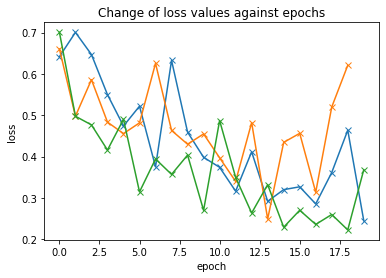

In [5]:
#gives different vals each time??
#0.001 was always the best performing one

#model1 = train_model(model, epochs=20, learning_rate=0.000001)
#model2 = train_model(model, epochs = 20, learning_rate = 0.0001)
model3 = train_model(model, epochs=20, learning_rate = 0.001)

#values in table are from running model1 thru model3
loss1 = [0.6418, 0.7007, 0.647,0.5499, 0.474, 0.522,0.3752, 0.6328, 
         0.4592, 0.3981, 0.374, 0.3162, 0.4114, 0.2917, 0.3199, 0.3268,
        0.2853, 0.3614, 0.4638, 0.2445]

loss2 = [0.6605, 0.4978, 0.5861, 0.4834, 0.4557, 0.4816, 0.6258, 0.4632,
        0.4299, 0.4548, 0.397, 0.3399, 0.4822, 0.2489, 0.4344, 0.4562,
        0.3136, 0.52, 0.6209, ]
loss3 = [0.701, 0.4976, 0.4767, 0.4158, 0.4901, 0.3145, 0.3942, 0.3568,
         0.4036, 0.2698, 0.4872, 0.3497, 0.2633, 0.3319, 0.229, 0.27, 
         0.2357, 0.2597, 0.2224, 0.3682]

plt.plot(loss1, '-x')
plt.plot(loss2, '-x')
plt.plot(loss3, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Change of loss values against epochs')

Using the step size you identified in Q6, train your model for certain number of epochs. You can decide the number of epoch by looking at how fast the loss value decreases. Normally, the loss values quickly drops at the beginning and reach a plateau after some number of epochs. Train the model until it reach the plateau.

Now we are ready to test our trained model.

### Q7. Evaluate the performance of your (trained) model. (10 pts)
- Load the iamages in the test folder.
- Apply the same transformation you defined in Q3.
- There are only 8 images in your `test` folder. You can set `batch_size=8` so that all of them are loaded in a batch.
- For each image, show
    - the image,
    - estimated class probability, i.e., $\Pr[Y=\text{'uga'}~|~X=x]$, and
    - the label.
    
To see how to display an image tensor, you refer to the following code. Suppose $X$ is a tensor containing the image you want to display.

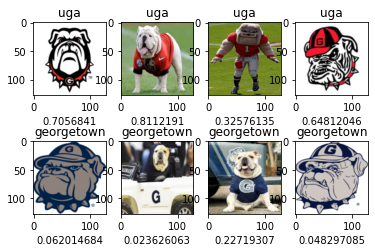

In [6]:
import math

transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
dataset_test = datasets.ImageFolder('dawgs/test', transform  = transform)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=8, shuffle = True)

fig, ax = plt.subplots(2,4)

batch = next(iter(test_loader))
images, labels = batch
outputs = model(images.view(-1,49152)).float()

for i in range(len(outputs)):
    ax[math.floor(i/4),i%4].imshow(np.transpose(images[i].numpy(), (1,2,0)))
    x = (outputs[i].detach().numpy()[0])
    ax[math.floor(i/4),i%4].set_xlabel(x)
    ax[math.floor(i/4),i%4].set_title(dataset_test.classes[labels[i].item()])
    
#print(outputs)

#print(labels)




### Q8. Find the image in your training set that is closest to the decision boundary and display it. (10 pts)
- This can be done by computing the class probabilities for all images in your training set and find one whose value is closest to 0.5.

image from dawgs/train folder NOT dawgs/test folder:
tensor([0.4995], grad_fn=<SelectBackward>)


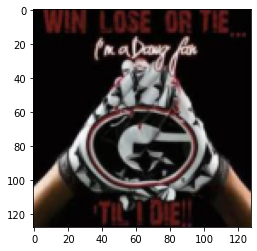

In [7]:
print("image from dawgs/train folder NOT dawgs/test folder:")
train = next(iter(train_loader))
image, label = train
output = model(image.view(-1,49152)).float()

value = 0.500000
idx1 = (abs(output.detach().numpy()-value)).argmin()
print(output[idx1])

for i in range(len(output)):
    x = (output[i].detach().numpy()[0])
    if plt.imshow(np.transpose(image[i].numpy(), (1,2,0))) == output[idx1]:
        plt.imshow(np.transpose(image[i].numpy(), (1,2,0)))
    

